In [5]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.cytoselfmodule import CytoselfLightningModule
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt



# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-02/18-43-45" # 6 epochs 
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/05-45-38" # 21 epochs 
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    clm = CytoselfLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        num_class=pdm.num_class,
    )

    clm.model.to('cuda')
    clm.model.eval()

/tmp/ipykernel_511/2438591544.py:15: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-08-03/05-45-38/checkpoints/last.ckpt


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


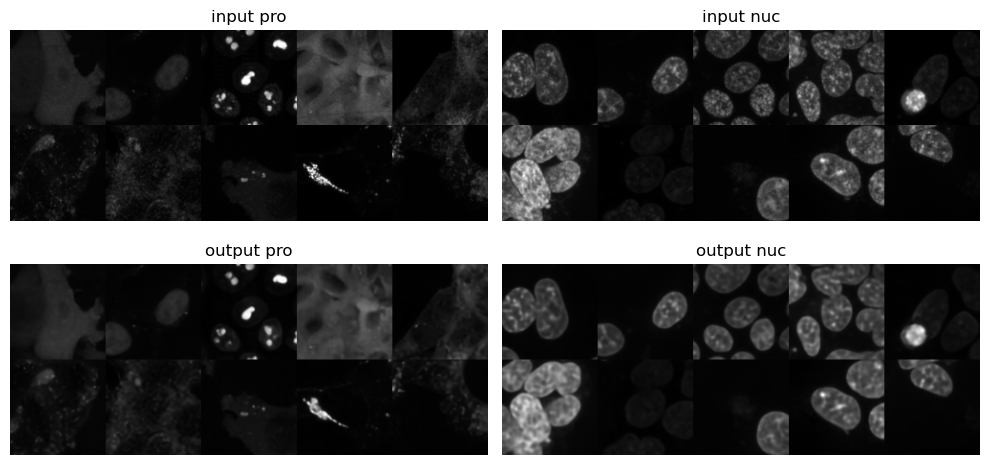

In [6]:
batch = next(iter(pdm.val_dataloader(novel_proteins=False, shuffle=True)))
input_images = batch['image'].to('cuda')
output_images, output_logits = clm.model(input_images)
output_images = output_images.detach().cpu().numpy()
input_images = input_images.detach().cpu().numpy()


data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [7]:
import torch
from tqdm import tqdm


embeddings = []
localizations = []
with torch.no_grad():
    for batch in tqdm(pdm.val_dataloader(novel_proteins=False, shuffle=False)):
        emb = clm.model(batch['image'].to('cuda'), 'vqvec2')
        embeddings.append(emb.detach().cpu().numpy())
        localizations.append(batch['localization'])
localizations = np.concatenate(localizations, axis=0)
embeddings = np.concatenate(embeddings, axis=0)

100%|██████████| 1435/1435 [00:57<00:00, 24.86it/s]


In [8]:
import zarr
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "good_embeddings_redo21.zarr")

shape = embeddings.shape
chunks = (100, None, None, None)
z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
z[:] = embeddings

np.save(join(datapath, "good_localizations_redo21.npy"), localizations)
# embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations = np.load(join(datapath, "good_localizations.npy"))

In [9]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [10]:
from joblib import dump
dump(reducer, join(datapath,'good_umap_model_redo21.joblib'))

['/home/ec2-user/cytoself-data/good_umap_model_redo21.joblib']

In [11]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))
localizations[localizations == ''] = 'other'

In [12]:
import seaborn as sns

In [13]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

<AxesSubplot:>

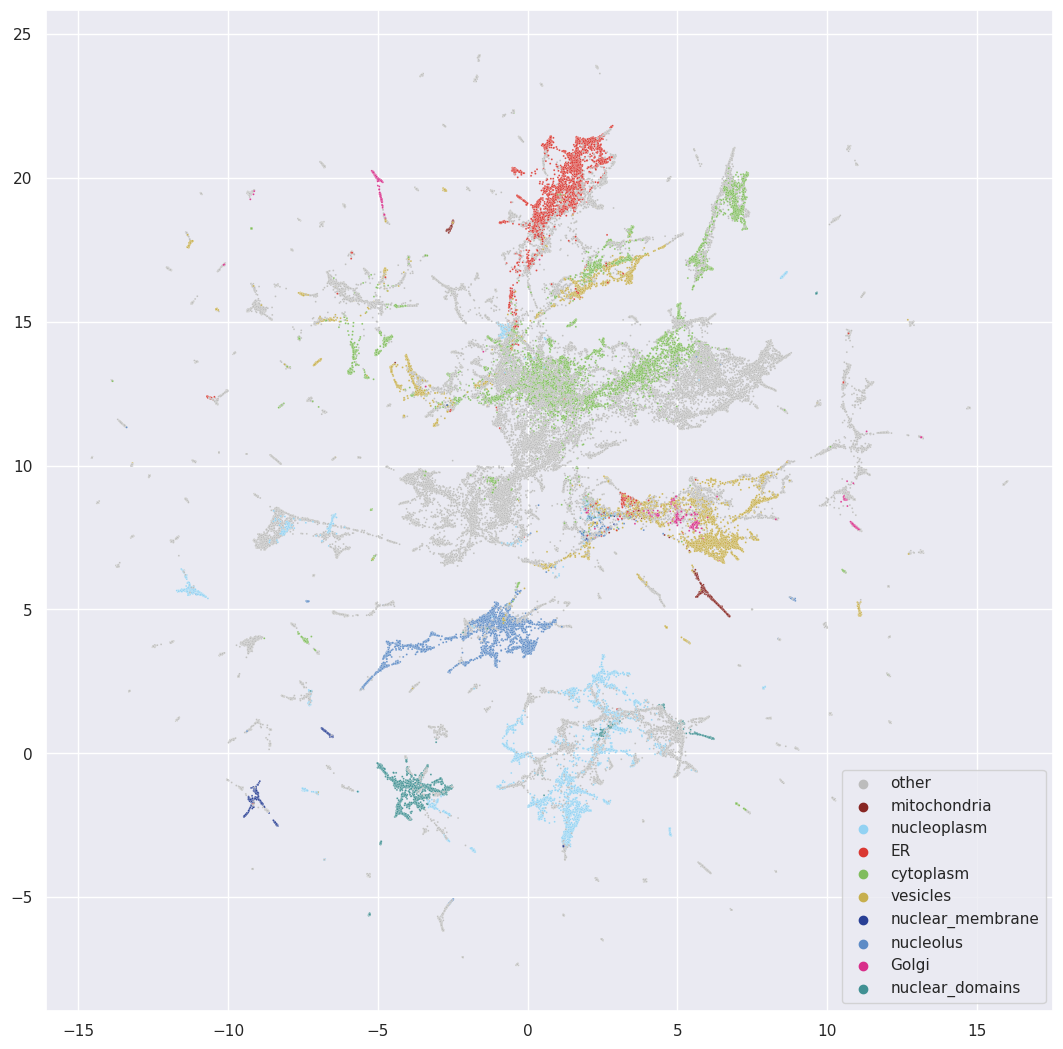

In [14]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

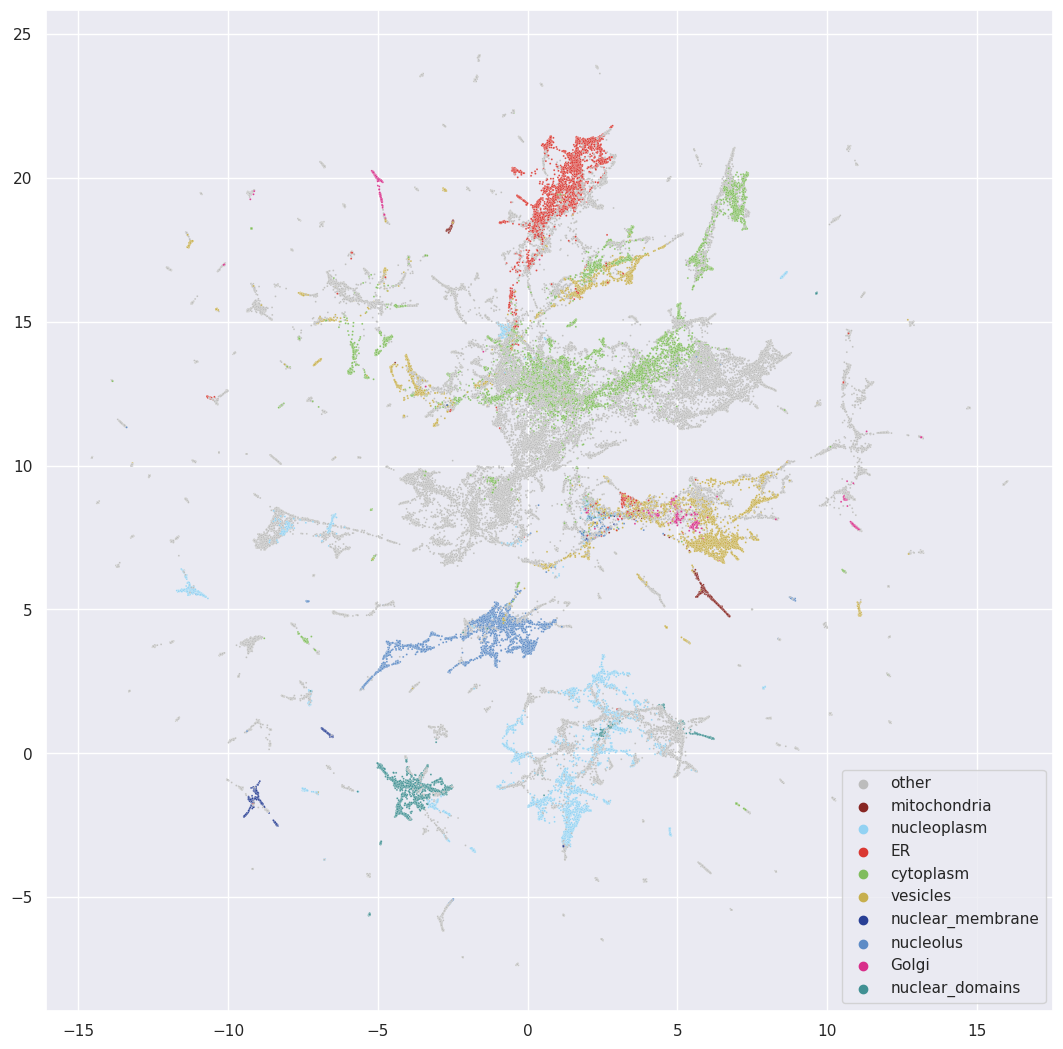

In [15]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

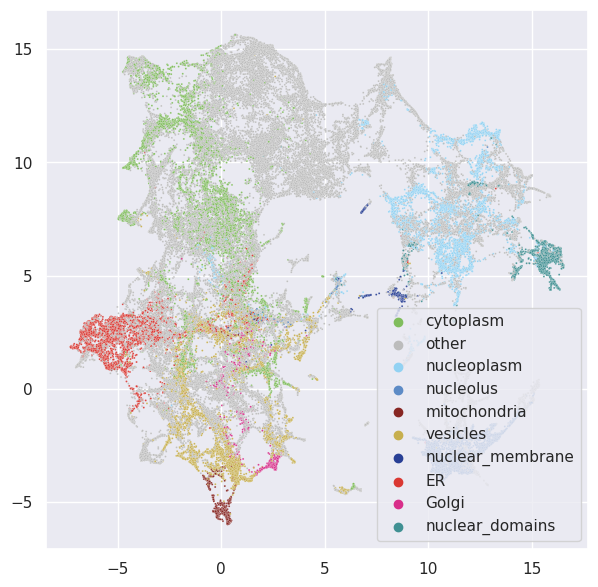

In [9]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

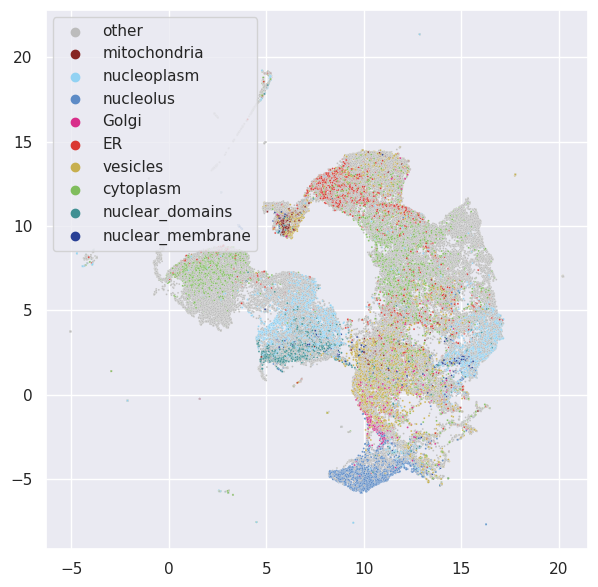

In [9]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)